### Deep learning model training.


In [1]:
import torch
import glob
import time
import random
import torch.nn as nn
from torchsummary import summary
from model.model.unet import unet
from utils.dataloader import Dataset
from utils.imgShow import imsShow
from utils.acc_metric import oa_binary, miou_binary


### dataset loading

In [2]:
paths_truth = sorted(glob.glob('data/dset/truth/*.tif'))
random.shuffle(paths_truth, random.seed(1))  # Set a seed for reproducibility
paths_scene = [path.replace('.tif', '.tif').replace('truth','scene') for path in paths_truth]
paths_dem = [path.replace('.tif', '_dem.tif').replace('truth','dem') for path in paths_truth]
## split the dataset into training and validation sets
## validation set (13 scenes)
paths_truth_val = paths_truth[:13]
paths_scene_val = paths_scene[:13]
paths_dem_val = paths_dem[:13]
## Training set (remaining scenes)
paths_truth_tra = paths_truth[13:]
paths_scene_tra = paths_scene[13:]
paths_dem_tra = paths_dem[13:]
len(paths_scene_val)


13

In [3]:
## Create dataset instances
tra_data = Dataset(paths_scene=paths_scene_tra, paths_truth=paths_truth_tra, paths_dem=paths_dem_tra)
val_data = Dataset(paths_scene=paths_scene_val, paths_truth=paths_truth_val, paths_dem=paths_dem_val)
tra_loader = torch.utils.data.DataLoader(tra_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)


In [4]:
patch, truth = tra_data[0]
patch.shape


torch.Size([7, 512, 512])

#### Model training

In [5]:
### check model
model = unet(num_bands=7)
summary(model, input_size=(7,256,256), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,024
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
         Upsample-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 64,

In [6]:
### create loss and optimizer
loss_bce = nn.BCELoss()     
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, tra_loader, 
                                    val_loader, epoches, device):
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        '''-----validation the model-----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.2f},Miou:{:.2f}, val-> Loss:{:.2f},Oa:{:.2f},Miou:{:.2f},time:{:.0f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))
        ## show the result
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch, truth = torch.unsqueeze(patch, 0).to(device), truth.to(device)
            pred = model(patch)
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            imsShow([patch, truth, pred], 
                    img_name_list=['input_patch', 'truth', 'prediction'] , figsize=(10,4))


Ep1: tra-> Loss:0.497,Oa:0.77,Miou:0.62, val-> Loss:0.67,Oa:0.62,Miou:0.32,time:32s
Ep2: tra-> Loss:0.348,Oa:0.85,Miou:0.65, val-> Loss:0.11,Oa:0.95,Miou:0.85,time:31s
Ep3: tra-> Loss:0.150,Oa:0.91,Miou:0.85, val-> Loss:0.25,Oa:0.83,Miou:0.72,time:31s
Ep4: tra-> Loss:0.149,Oa:0.92,Miou:0.86, val-> Loss:0.11,Oa:0.94,Miou:0.88,time:31s
Ep5: tra-> Loss:0.129,Oa:0.94,Miou:0.88, val-> Loss:0.17,Oa:0.86,Miou:0.80,time:31s
Ep6: tra-> Loss:0.104,Oa:0.94,Miou:0.90, val-> Loss:0.09,Oa:0.96,Miou:0.92,time:31s
Ep7: tra-> Loss:0.125,Oa:0.92,Miou:0.84, val-> Loss:0.14,Oa:0.88,Miou:0.84,time:31s
Ep8: tra-> Loss:0.094,Oa:0.95,Miou:0.92, val-> Loss:0.05,Oa:0.86,Miou:0.80,time:31s
Ep9: tra-> Loss:0.113,Oa:0.95,Miou:0.88, val-> Loss:0.06,Oa:0.93,Miou:0.86,time:31s
Ep10: tra-> Loss:0.111,Oa:0.92,Miou:0.86, val-> Loss:0.07,Oa:0.91,Miou:0.89,time:31s


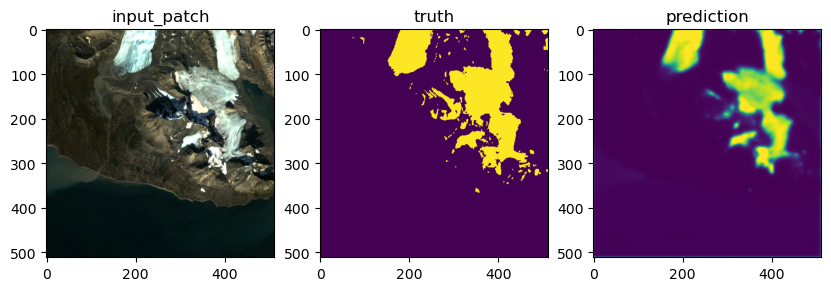

Ep11: tra-> Loss:0.133,Oa:0.94,Miou:0.89, val-> Loss:0.07,Oa:0.92,Miou:0.86,time:31s
Ep12: tra-> Loss:0.094,Oa:0.92,Miou:0.89, val-> Loss:0.05,Oa:0.84,Miou:0.83,time:31s
Ep13: tra-> Loss:0.101,Oa:0.94,Miou:0.90, val-> Loss:0.06,Oa:0.97,Miou:0.95,time:31s
Ep14: tra-> Loss:0.096,Oa:0.93,Miou:0.89, val-> Loss:0.06,Oa:0.81,Miou:0.79,time:31s
Ep15: tra-> Loss:0.109,Oa:0.94,Miou:0.90, val-> Loss:0.07,Oa:0.85,Miou:0.81,time:31s
Ep16: tra-> Loss:0.101,Oa:0.93,Miou:0.90, val-> Loss:0.09,Oa:0.96,Miou:0.93,time:31s
Ep17: tra-> Loss:0.077,Oa:0.96,Miou:0.93, val-> Loss:0.08,Oa:0.95,Miou:0.87,time:31s
Ep18: tra-> Loss:0.093,Oa:0.94,Miou:0.90, val-> Loss:0.08,Oa:0.95,Miou:0.91,time:31s
Ep19: tra-> Loss:0.083,Oa:0.95,Miou:0.91, val-> Loss:0.05,Oa:0.85,Miou:0.84,time:31s
Ep20: tra-> Loss:0.077,Oa:0.93,Miou:0.89, val-> Loss:0.06,Oa:0.96,Miou:0.93,time:31s


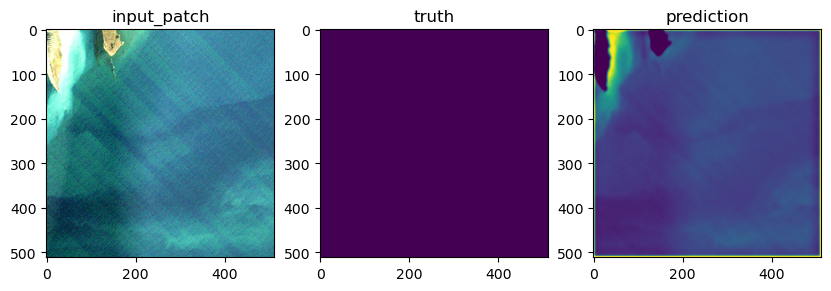

In [8]:
# device = torch.device('cpu') 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loops(model=model, 
            loss_fn=loss_bce, 
            optimizer=optimizer,
            tra_loader=tra_loader, 
            val_loader=val_loader, 
            epoches=20,
            device=device)


In [9]:
# # model saving
# path_save = 'model/trained/unet_l5789_s2.pth'
# torch.save(model.state_dict(), path_save)   # save weights of the trained model 
# model.load_state_dict(torch.load(path_save, weights_only=True))  # load the weights of the trained model
